In [1]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

import warnings
warnings.filterwarnings("ignore")

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')

#Movies were not able to save until
#ffmpeg is installed into the environment.

![title](figs/title.png)

<h1><center>Module 03: Differentiation and Discretization</center></h1>

This module is largely focused on theory and practice of taking **analytic** partial differential equations (PDEs) defined on a **continuum** such as the 1D advection equation:

$$\frac{\partial U}{\partial t}+c\frac{\partial U}{\partial x} = 0, \tag{1} $$

and replacing it with a **discretized** version that is appropriate for generating **numerical solutions** on **discrete computational grid**.  

Why are we interested in doing such a thing? The answer largely lies in the fact that there are only a limited number of analytical solutions to almost all PDEs, and these are restricted to idealized scenarios (e.g., homogeneous medium, simple boundary conditions).  The real world, though, is inherently complex and cannot be simply defined by these idealized analytic scenarios. To address these situations, we must turn to **numerical solutions** of these PDEs.  In doing so, however, we run into a whole new class of challenges including **numerical stability**, **approximation accuracy**, and **computational efficiency** to name just a few. The purpose of this module is to start introducing some of these concepts within the context of numerical **differentiation** and **discretization**.   

## The Derivative Definition

Let's begin this module with a quick refresher on the definition of the derivative.  In your study of calculus over the previous number of years, you have no doubt encountered the following definition of the first derivative of function $f(t)$ defined on some interval $t\in[a,b]$:

$$ f^\prime(t) = \lim_{\Delta t\rightarrow 0} \frac{f(t+\Delta t)-f(t)}{\Delta t},  \tag{2}$$

where the $^\prime$ symbol indicates the derivative, and $\Delta t$ for a small increment. There are a number of other criteria that needs to be considered (e.g., continuity, differentiability); however, in this course we will assume that the functions under consideration are well-behaved such that these are not an issue.

### The Limits of Limits

Because we are interested in **discrete** solutions in this module, we are dealing with scenarios where we have some minimum **discrete** sampling of the continuous time axis: $\Delta t$. In these scenarios, we cannot take the limit of $\Delta t \rightarrow 0$ as is required by definition of the derivative.  Thus, we are left with a **numerical approximation** of the continuous derivative:

$$ f^\prime(t) = \frac{df}{dt} \approx \frac{\Delta f}{\Delta t} = \frac{f(t+\Delta t)-f(t)}{\Delta t}. \tag{3}$$

Note that we have had to introduce the approximate symbol $\approx$ since these are not formally equal.  However, we can introduce equality by rewriting this equation as

$$ f^\prime(t) = \frac{df}{dt} = \frac{f(t+\Delta t)-f(t)}{\Delta t} +\mathcal{O}(\Delta t^2), \tag{4}$$

where $\mathcal{O}(\Delta t^2)$ indicates that there are **higher-order terms** proportional to at least $\Delta t^2$ that contribute to this equation in this case **second-order** terms such that equation 4 represents a **first-order approximation**.  

To think of why this would be important, consider if $\Delta t < 1$ is small, then $\Delta t^2 << 1$ will be much smaller; thus, an $\mathcal{O}(\Delta t^2)$ apprximation will be more accurate than an $\mathcal{O}(\Delta t)$ one.  Note that the $\mathcal{O}(\Delta t^n)$ term is often implicitly assumed and is only written when required for clarity.

## Taylor Series

Let's now bring in Taylor Series to help us better understand why the above expression is only a first-order expression.  Recall that Taylor's theorem with remainder gives the following expression:

$$f(t+\Delta t) = f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(\tilde t)}{2!}, \tag{5}$$

where it is assumed that all of the derivitives are evaluated at $t$ (and not $t+\Delta t$).  Rearranging this equation leads to the following:

$$\frac{f(t+\Delta t) - f(t)}{\Delta t} -f^\prime(t) =  \Delta t \frac{f^{\prime\prime}(\tilde t)}{2!} = \mathcal{O}(\Delta t),\tag{6}$$

the right-hand side of which tells us that the **numerical error** is proportional to $\Delta t$ and thus this expression represents a **first-order approximation**.  

### Forward and Backward Approximations

So far, it is likely that you have been thinking of $\Delta t$ as a small **positive** quantity; however, we did not formally include positivity in its definition.  This definition is called a **forward approximation** of $f^\prime(t)$ because it is defined using information at $t$ and $t+\Delta t$, which is $\Delta t$ forward of $t$.

Let's now say that we have new small **negative** quantity $\Delta t^\prime$ such that $\Delta t^\prime=-\Delta t$.  How does this affect the expression in equation 6?

$$\frac{f(t-\Delta t^\prime) - f(t)}{-\Delta t^\prime} - f^\prime(t) = \frac{f(t) - f(t-\Delta t^\prime) }{\Delta t^\prime} - f^\prime(t) = - \Delta t^{\prime} \frac{f^{\prime\prime}(\tilde t)}{2!}. \tag{7}$$

Thus, the middle equality of equation 7 has the same form as equation 6; however, it now requires information at $t$ and $t-\Delta t$, which $\Delta t$ units behind $t$. Thus, this expression is called a **backward approximation** of $f^\prime(t)$.  You'll also note that the error is again proportional to $\Delta t^\prime$. Thus, as one may expect, this expression is also a **first-order approximation** just like equation 6. This is a choice that is made when you numericalize your equation. There are some interesting consequences that result from this choice as well, so it is not completely arbitrary (possibly pragmatic?).

## Higher-order Taylor Series Approximations

Let's now look at combining different Taylor Series approximations to see if we can generate a higher-order expression (i.e., the error term is proportional to at least $\Delta t^2$).  Here are the forward and backward Taylor-Series approximations defined in equations 6 and 7 above, but now expanded out in a higher-order approximation:

$$f(t+\Delta t) = f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}, \tag{8a}$$

$$f(t-\Delta t) = f(t) - \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}. \tag{8b}$$

Now, by subtracting equation 8b from 8a we can obtain the following:

$$f(t+\Delta t) - f(t-\Delta t) = 2 \Delta t f^\prime(t) + 2\Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}. \tag{9a}$$

Dividing through by $2\Delta t$ and rearranging this expression yields:

$$\frac{f(t+\Delta t)-f(t-\Delta t)}{2\Delta t} - f^\prime(t) = \Delta t^2 \frac{f^{\prime\prime\prime}(t)}{3!}. \tag{9b}$$

Unlike equation 7, you'll notice that the right-hand side error term is now proportional to $\Delta t^2$. Thus, this represents a **second-order centered approximation** of $f^\prime(t)$.  Here, we use the term **centered** because this expressions depends on an equal number of points before ($t-\Delta t)$ and after ($t+\Delta t)$ the point being evaluated ($t$).

Can we go even higher? The answer is yes; however, the mathematics get a bit more tedious.  I'll show a **fourth-order approximation** can be derived.

$$
\begin{eqnarray}
f(t+\Delta t) &=& f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ \Delta t^4 \frac{f^{(4)}(t)}{4!}+ \Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10a} \\
f(t-\Delta t) &=& f(t) - \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ \Delta t^4 \frac{f^{(4)}(t)}{4!}- \Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10b} \\
f(t+2\Delta t) &=& f(t) + 2\Delta t f^\prime(t) + 4\Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + 8\Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ 16\Delta t^4 \frac{f^{(4)}(t)}{4!}+ 32\Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10c}\\
f(t-2\Delta t) &=& f(t) - 2\Delta t f^\prime(t) + 4\Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - 8\Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ 16\Delta t^4 \frac{f^{(4)}(t)}{4!}- 32\Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10d}\\
\end{eqnarray}$$

If we first subtract equation 10b from 10a and multiply by 8 we obtain:

$$8f(t+\Delta t)-8f(t-\Delta t) = 16 \Delta t f^\prime(t)+\frac{16\Delta t^3}{3!}f^{\prime\prime\prime}(t)+\frac{16\Delta t^5}{5!}f^{(5)}(t). \tag{10e}$$

where the purpose of the factor of 8 is to get the value of 16 in the $\Delta t^3$ term. If we then subtract equation 10d from 10c we obtain:

$$f(t+2\Delta t)-f(t-2\Delta t) = 4 \Delta t f^\prime(t)+\frac{16\Delta t^3}{3!}f^{\prime\prime\prime}(t)+\frac{64\Delta t^5}{5!}f^{(5)}(t). \tag{10f}$$

Now we see that the $\Delta t^3$ coefficients match and can be easily eliminated.  Subtracting equation 10e from 10f obtains:

$$f(t+2\Delta t)-8f(t+\Delta t)+8f(t-\Delta t)-f(t-2\Delta t) - 12 \Delta t f^\prime(t) = \frac{48\Delta t^5}{5!}f^{(5)}.\tag{10g} $$

Finally, dividing through by $12 \Delta t$ yields:

$$\frac{f(t+2\Delta t)-8f(t+\Delta t)+8f(t-\Delta t)-f(t-2\Delta t)}{12 \Delta t} -  f^\prime(t) = \frac{4\Delta t^4}{5!}f^{(5)}. \tag{10g} $$

Thus, after all of this math, we see that the right-hand side error term is proportional to $
\Delta t^4$. Thus, equation 10g represents a **fourth-order centered approximation** of $f^\prime(t)$.  There are other expressions for higher-order approximations as well; however, these get much much more tedious ...

This makes intuitive sense. The more known about the surrounding area of a point, then its derivative can be known with more accuracy (i.e. a smaller $\mathcal{O}(\Delta t)$). However, there are limitations present. The higher-order the approximations, the more information we need to know (points, boundary conditions, etc.)


### A Simplifying Notation

Writing equation 10g in the full form can also be tedious; however, there is a fairly **compact** and general way to represent **nth-order centered approximations** (where $n$ is an even integer) of the first derivative:

$$f^\prime(t) \approx \frac{1}{\Delta t}\sum_{k=-n/2}^{n/2} c_k f(t+k\Delta t), \tag{11}$$

where $c_k$ are [finite-difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient).  Thus, for equation 10g, if we set $n=4$ in equation 11 and then define $c_k = [c_{-2},c_{-1},c_0,c_1,c_2] = [\frac{1}{12},-\frac{2}{3},0,\frac{2}{3},-\frac{1}{12}]$, we see that equation 11 can represent equation 10g.

A more complete list for second- through eight-order approximations are given in Table 1 below.  You'll notice that all of the coefficients are **odd** such that $c_{-k}=-c_k$.

Derivative|Accuracy| −4	 | −3   | −2 |	−1 | 0 | 1 |  2  |  3  | 4 
----------|--------|-----|------|----|-----|---|---|-----|-----|---
1         |	  2	   | 0   |  0   |0   |−1/2 | 0 |1/2| 0   | 0   |0  				
1         |   4	   |0    |	0   |1/12|−2/3 | 0 |2/3|−1/12|	0   |0
1         |   6	   |0    |−1/60 |3/20|−3/4 | 0 |3/4|−3/20|1/60 | 0		
1         |   8	   |1/280|−4/105|1/5 |−4/5 | 0 |4/5| −1/5|4/105| −1/280	

**Table 1. List of finite-difference coefficients for centered first derivatives corresponding to the compact notation in equation 11.  Note that to apply these in an actual implementation you will need to divide by $\Delta t$.**

Finally, if you went to the webpage [finite-difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient), you may have noticed that there also also one-sided version of finite-difference coefficients.  These are not commonly used; however, they do have applications in some problems when one is trying to apply high-order finite-difference approximations near computational domain boundaries.

## Higher-order derivatives

So far we have just been discussing approximations for first derivatives; however, in the following modules we will be definitely be needing numerical expressions for second derivatives.  To see how approximations for $f^{\prime\prime}(t)$ can be generated, let's again start with equations 8a and 8b:

$$f(t+\Delta t) = f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ \Delta t^4 \frac{f^{(4)}(t)}{4!}, \tag{12a}$$

$$f(t-\Delta t) = f(t) - \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+\Delta t^4 \frac{f^{(4)}(t)}{4!}. \tag{12b}$$

We can now add these two expressions (rather than subtract them) to yield:

$$f(t+\Delta t) + f(t-\Delta t)= 2 f(t) + 2\Delta t^2 \frac{f^{\prime\prime}(t)}{2!}+ 2\Delta t^4 \frac{f^{(4)}(t)}{4!}. \tag{13a}$$

Rearranging terms, cancelling out 2/(2!), and dividing through by $\Delta t^2$ results in

$$\frac{f(t+\Delta t) -2f(t) + f(t-\Delta t)}{\Delta t^2} - f^{\prime\prime}(t) = \frac{\Delta t^2}{12} f^{(4)}(t). \tag{13b}$$

Thus, the expression in equation 13b represents a **second-order centered approximation** of $f^{\prime\prime}(t)$.

As one might expect from the section above, one can manipulate the Taylor-series expansions in order to create **higher-order** second derivatives.

A more complete list for second- through eight-order approximations for second derivatives are given in Table 2 below (again from [finite-difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient)).  You'll notice that all of the coefficients are **even** such that $c_{-k}=c_k$.

Derivative|Accuracy| −4	  | −3   | −2  |  −1 |  0    | 1 |  2  |  3   | 4 
----------|--------|------|------|-----|-----|------ |---|-----|------|---
2         |	  2	   |	0 |   0  |0    | 1   | -2    | 1 | 0   |  0   |0 				
2         |   4	   |	0 |	0    |-1/12|4/3  | -5/2  |4/3|−1/12|	0  |0
2         |   6	   |0     | 1/90 |-3/20| 3/2 |-49/18 |3/2|−3/20|1/90  | 0		
2         |   8	   |-1/560|8/315 |-1/5 |8/5  |-205/72|8/5| −1/5| 8/315| −1/560	

**Table 2. List of finite-difference coefficients for centered second derivatives corresponding to the compact notation in equation 11. Note that to apply these in an actual implementation you will need to divide by $\Delta t^2$.**


### Note on implementing stencils

One way to apply these stencils is through a convolution operation.  However, if these were truly convolution then we would expect the following equation:

$$f^\prime(t) \approx \frac{1}{\Delta t}\sum_{k=-n/2}^{n/2} c_{-k} f(t+k\Delta t), $$

where the coefficients are reversed.  Thus, if you have a time-series trace (*trace* below) and want to apply a FD stencil (*FDstencil* below) then you would need to implement


   * *numpy.convolve(trace, FDstencil[::-1], mode='same')*


where *FDstencil[::-1]* effectively reverses the stencil array.

Let's look at an example using an $O(\Delta t^2)$ first derivative below using sin and cosine functions:

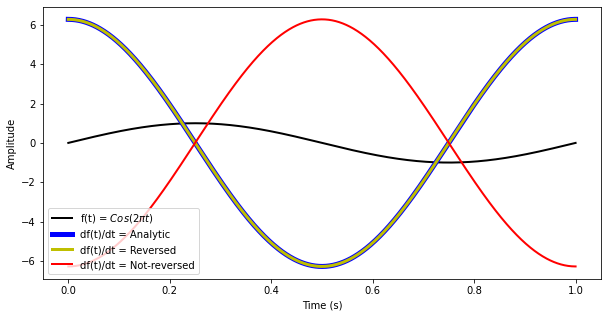

In [2]:
nt,dt=1001,0.001
t = np.arange(nt)*dt

f = np.sin(2*np.pi*t)
dfdt_true = 2*np.pi*np.cos(2*np.pi*t)

## . . First-order first derivative stencil fom Table 7-1 
FDstencil = [-1/2,0,1/2]

## . . With reversed stencil
dfdt_good = np.convolve(f,FDstencil[::-1],mode="same") / dt #<--- divide by dt!

## Treat ends (zero slope)
dfdt_good[0]=dfdt_good[1]
dfdt_good[nt-1]=dfdt_good[nt-2]

## . . Without reversed stencil
dfdt_bad  = np.convolve(f,FDstencil      ,mode="same") / dt #<--- divide by dt!

## Treat ends (zero slope)
dfdt_bad[0]=dfdt_bad[1]
dfdt_bad[nt-1]=dfdt_bad[nt-2]

plt.figure(figsize=(10,5))
plt.plot(t,f,'k-',Linewidth=2)
plt.plot(t,dfdt_true,'b-',Linewidth=5)
plt.plot(t,dfdt_good,'y-',Linewidth=3)
plt.plot(t,dfdt_bad,'r-',Linewidth=2)
plt.legend(['f(t) = $Cos(2\pi t)$','df(t)/dt = Analytic','df(t)/dt = Reversed','df(t)/dt = Not-reversed'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

**Figure 1. Demonstration of the need to reverse filter coefficients when using *np.convolve()* statement.  The black line is the signal $f(t)=\cos(2\pi t)$ while the blue line is its analytic derivative $df(t)/dt=2\pi \sin(2\pi t)$. The yellow line (falling on the blue line) is the numerical derivative with the reversed coefficients.  The red line is when you do not reverse the coeffcients. Note that I have divided by $\Delta t$ in the code to get the correct amplitude scaling.**

### Handling (Combinations of) Partial Derivatives

In almost all cases we will be looking at solving PDEs that are of at least two variables (e.g., $U(x,t)$).  Thus, how do we approach discritzation in these scenarios? Actually, this case is pretty straightforward. Let's say that we're looking to obtain a discretized version of the following using a second-order approximation of the first spatial derivative.  This would imply that

$$c\frac{\partial U(x,t)}{\partial x} \approx c\left(\frac{U(x+\Delta x,t)-U(x-\Delta x,t)}{2\Delta x}\right).\tag{14a}$$

Similarly, if we want to obtain a discretized version of the following using a second-order approximation of the first temporal derivative, this would imply that

$$\frac{\partial U(x,t)}{\partial t} \approx \frac{U(x,t+\Delta t)-U(x,t-\Delta t)}{2\Delta t}.\tag{14b}$$

Thus, combining equations 14a and 14b, if wanted to have a discrete version of both partial derivatives, then we'd have 

$$\frac{\partial U(x,t)}{\partial t} + c\frac{\partial U(x,t)}{\partial x} \approx \frac{U(x,t+\Delta t)-U(x,t-\Delta t)}{2\Delta t}+ c\left( \frac{U(x+\Delta x,t)-U(x-\Delta x,t)}{2\Delta x}\right). \tag{14c} $$

We see that the effective **partial differential operator** on the left-hand side generates the following pattern called a **finite-difference stencil** on the right-hand side that consists of the four points visualized below:

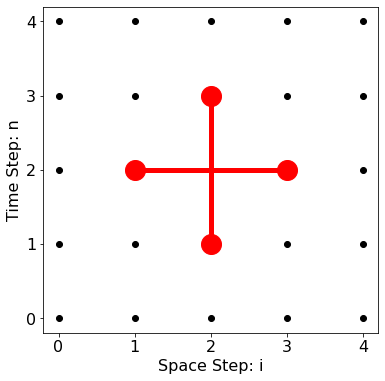

In [3]:
plt.figure(figsize=(6,6))
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
plt.plot(1,2,'ro',ms=20)
plt.plot(3,2,'ro',ms=20)
plt.plot([1,3],[2,2],'r-',linewidth=5)
plt.plot(2,1,'ro',ms=20)
plt.plot(2,3,'ro',ms=20)
plt.plot([2,2],[1,3],'r-',linewidth=5)

plt.ylabel('Time Step: n',fontsize=16)
plt.yticks(range(5),fontsize=16)
plt.xlabel('Space Step: i',fontsize=16)
plt.xticks(range(5),fontsize=16)
plt.show()

**Figure 2. Example of a finite-difference stencil for the advection equation.**

### Indicial Notation

The notation on the right-hand side of equation 14c is a bit cumbersome because one has to write out all of the spatial and temporal dependences.  Thus, there is great advantage in developing some sort of short form. In this case we can switch to index notation where **subscript indices** represent the spatial coordinate (usually the letter $i$) and **superscript indices** represent the temporal coordinate (usually using the letter $n$). 

$$
U^{n \text{: temporal coordinate}}_{i \text{: spatial coordinate}}
$$

Thus, we can rewrite equation 14c as the following:

$$\begin{eqnarray}
\frac{\partial U(x,t)}{\partial t} + c\frac{\partial U(x,t)}{\partial x}&\approx & \frac{U(x,t+\Delta t)-U(x,t-\Delta t)}{2\Delta t}+c\left(\frac{U(x+\Delta x,t)-U(x-\Delta x,t)}{2\Delta x}\right) \\
&\approx& \frac{1}{2\Delta t}\left(U^{n+1}_{i}-U^{n-1}_{i}\right)+\frac{c}{2\Delta x}\left(U^n_{i+1}-U^n_{i-1}\right), \tag{15a}
\end{eqnarray}$$

where in Figure 7-1 I have plotted the stencil for $[i,n]=[2,2]$. Note that compact notation easily can be extended to 2D (indicies $i,j$) or 3D (indicies $i,j,k$) spatial dimension scenarios using expressions like:

$$\begin{eqnarray}
\frac{\partial U(x,y,z,t)}{\partial t}+ c\left(\frac{\partial U(x,y,z,t)}{\partial x}+\frac{\partial U(x,y,z,t)}{\partial y}+\frac{\partial U(x,y,z,t)}{\partial z} \right)
\approx &&\\
\frac{1}{2\Delta t}\left(U^{n+1}_{i,j,k}-U^{n-1}_{i,j,k}\right)+ \frac{c}{2\Delta x}\left(U^n_{i+1,j,k}-U^n_{i-1,j,k}\right) + \frac{c}{2\Delta y}\left(U^n_{i,j+1,k}-U^n_{i,j-1,k}\right)+ \frac{c}{2\Delta z}\left(U^n_{i,j,k+1}-U^n_{i,j,k-1}\right),&& \tag{15b}
\end{eqnarray} $$

which is much more compact that writing out all of the variable dependencies!

# Discretizing the 1D Advection Equation

One of the more straightforward PDEs to think about apply the above numerical derivative schemes to is the [advection equation](https://en.wikipedia.org/wiki/Advection).  This equation represents the transport of a substance or quantity by bulk motion. For example, the advection of pollutants or silt down a river. (Note that this is different than [convection](https://en.wikipedia.org/wiki/Convection) which combines advection with diffusion, which is a much more complex process to model.) 

The PDE governing advection of, say, a pollutant in a stream $U=U(x,t)$ is given by:

$$
\begin{eqnarray}
{\rm PDE:} & \quad & \frac{\partial U}{\partial t}+c\frac{\partial U}{\partial x} = 0, \quad x\in[0,1], \quad t\in[0,1] \tag{16a}\\
{\rm Initial\, Condition:} & \quad & U(x,t=0)= e^{-(x-0.5)^2/\sigma^2}\tag{16b}\\
{\rm Boundary\, Conditions:} & \quad & U(x=0,t) = 0,  U(x=1,t) = 0\tag{16c}
\end{eqnarray}
$$

where $c$ is the speed of the material transport (e.g., rate of water flow).  Note that we are solving the advection problem on a solution domain $x\in[0,1]$ and $t\in[0,1]$ and have imposed initial condition such that $U(x,t=0)= e^{-(x-0.5)^2/10}$ and for the boundaries $U(x=0,t)=0$ and $U(x=1,t)=0$. 

## Analytic Solution

Let's first remind ourselves what the **general** solution to the PDE actually is (ignoring the boundary conditions for now). To obtain the solution we can follow the **separation of variables** approach.  First, assume that the general solution $U(x,t)$ may be represented as the product of two functions, one purely of space $X(x)$ and the other purely of time $T(t)$.  Thus, $U(x,t)=X(x)T(t)$.  Let's now put this into equation 16a above to get:

$$XT^\prime+ c T X^\prime = 0 \tag{17a}$$

We can now divide through by $-cXT$ and rearrange the above to yield

$$-\frac{T^\prime}{cT} = \frac{X^\prime}{X} = ik, \tag{17b}$$

where the third equality represents the **separation constant** and $k$ is the wavenumber.  Let's now write the two equations of a single variable (and thus ODEs):

$$\begin{eqnarray}
X^\prime &=& ik X \tag{17c} \\
T^\prime &=& -ikc T \tag{17c} \\
\end{eqnarray}$$

The solutions to these two equations are $X = Ae^{ikx}$ and $T=Be^{-ickt}$ and thus the general solution is given by:

$$U(x,t) = Ce^{ik(x-ct)},\tag{17e}$$

where I have used $C=AB$.  Thus, the interpretation of this analytic solution is that the **initial solution should travel to the left or right** (depending on whether $c$ is positive or negative), but it **should not change shape**.  To get the actual specific solution satisfying the initial and boundary conditions would require superimposing different Fourier solutions weighted by the difference coefficients $C_n$; however, this discussion goes beyond the scope of the current presentation.

## Numerical Solutions

Let's now say that we are looking to solve this equation numerically on a "grid" or "mesh".  In this case we have to choose our **discretization interval**, which effectively is how we sample our numerical solution grid in space and time.  Let's say that we choose $\Delta t = 0.04$ s and $\Delta x = 0.04$ m as our time and space discretization intervals. Since our domains are defined by $x\in[0,1]$ and $t\in[0,1]$, this means that we have $I \times N=26 \times 26$ grid points in our numerical solution.

To illustrate what the solution grids looks like, I plot a graphical representation of it in the figure below. Here, I've plotted two different colors.  The green circles are those points on the solution grid where we already know the solution (i.e., because of the initial and boundary conditions).  The black circles are those points in the solution domain where the solution is unknown. Thus, the goal of computing the finite-difference solution of the PDE is to use the information that is currently defined on the green points to calculate quantities on the black points.

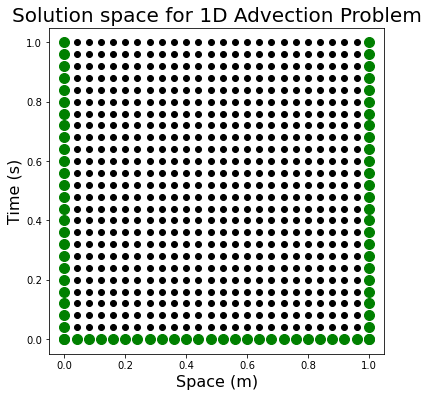

In [4]:
plt.figure(figsize=(6,6))
nx=ny=26
x = np.arange(nx)/(nx-1)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1/(nx-1)
plt.plot(x,np.zeros(ny),'go',ms=10)
plt.plot(np.zeros(ny),x,'go',ms=10)
plt.plot(np.zeros(ny)+1,x,'go',ms=10)    
plt.ylabel('Time (s)',fontsize=16)
plt.xlabel('Space (m)',fontsize=16)
plt.title('Solution space for 1D Advection Problem',fontsize=20)
plt.show()

**Figure 3. Solution domain $D$ for the advection equation at discete solution points $u_{i}^n$. The black dots represent locations where the solution is not known.  The green dots are the locations where the solution is known because of the initial and boundary conditions.**

### Solution by *explicit* FTCS method

Let's now think about how we are going to discretize the partial deriatives in equation 16a.  We'll start with what a Forward in Time and Centered in Space (or FTCS) method.  To compute such a solution we need to use a **first-order forward difference** in time at each spatial grid point $i$:

$$\frac{\partial U}{\partial t} \approx \frac{U^{n+1}_i - U^{n}_i}{\Delta t}, \tag{18a}$$

and then use a **second-order centered difference** in space at each temporal grid point $n$:

$$\frac{\partial U}{\partial x} \approx \frac{U^{n}_{i+1} - U^{n}_{i-1}}{2\Delta x}. \tag{18b}$$

We can now use these approximations to generate a **finite-difference stencil** representing the 1D advection PDE in equation 16a 

$$ \frac{U^{n+1}_i - U^{n}_i}{\Delta t}  + c \left(\frac{U^{n}_{i+1} - U^{n}_{i-1}}{2\Delta x} \right)=0, \tag{18c}$$

that is first-order accurate in time and second-order accurate in space. A compact way to write this level of accuracy is $\mathcal{O}\left(\Delta t, \Delta x^2  \right)$.

If, for a moment, we assume that $n=0$, we see that we know all of the quantities in equation 17c - except for the value of $U^{n+1}_{i}$.  Thus, let's multiply both sides by $\Delta t$ and rearrange equation 17c where all of the unknown terms at time points $n+1$ are on the left and all the known terms at time points $n$ are on the right:

$$U^{n+1}_i  =  U^{n}_i -\frac{c\Delta t}{2\Delta x}\left(U^{n}_{i+1} - U^{n}_{i-1}\right), \tag{18d}$$

or if we define a dimensionless quantity $\gamma_{FTCS} = \frac{c\Delta t}{2\Delta x}$, then we have:

$$U^{n+1}_i  =  U^{n}_i -\gamma_{FTCS} \left(U^{n}_{i+1} - U^{n}_{i-1}\right). \tag{18e}$$

Because the only unknown grid point is **explictly** defined by all of the other points, this type of approach is called an **explict finite-difference solution.** Graphically, this stencil centered about $[i,n]=[2,2]$ looks like the following:

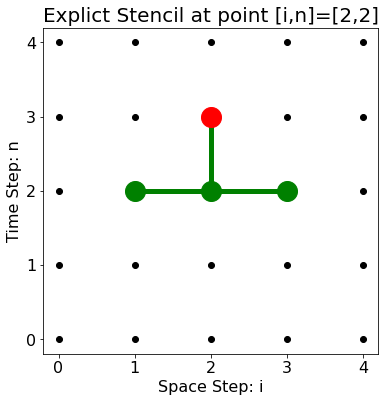

In [5]:
plt.figure(figsize=(6,6))
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
    
# . . Solution at point i
plt.plot(1,2,'go',ms=20)
plt.plot(3,2,'go',ms=20)
plt.plot([1,3],[2,2],'g-',linewidth=5)
plt.plot(2,2,'go',ms=20)
plt.plot([2,2],[2,3],'g-',linewidth=5)
plt.plot(2,3,'ro',ms=20)

plt.ylabel('Time Step: n',fontsize=16)
plt.yticks(range(5),fontsize=16)
plt.xlabel('Space Step: i',fontsize=16)
plt.xticks(range(5),fontsize=16)

plt.title('Explict Stencil at point [i,n]=[2,2]',fontsize=20)
plt.show()

**Figure 4. Explicit stencil for a FTSC solution of the advection equation.  Known points are given in green while the unknown point is in red.**

where the known values in green are used to calculate the single unknown value in red.  In the above figure I have simply chosen a value of $[i,n]=[2,2]$; however, this **stencil** is also applicable to all of the other points in the grid.  For example, one can think of stencils at neighbouring points  $[i,n]=[1,2]$ and  $[i,n]=[3,2]$ to be very similar!

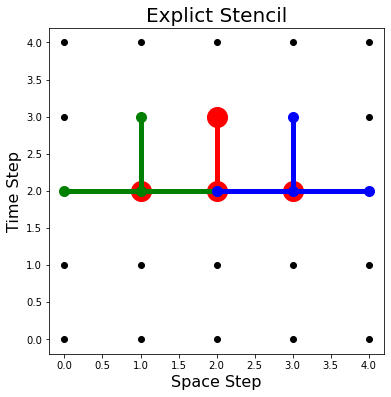

In [6]:
plt.figure(figsize=(6,6))
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
    
# . . Solution at point i
plt.plot(1,2,'ro',ms=20)
plt.plot(3,2,'ro',ms=20)
plt.plot([1,3],[2,2],'r-',linewidth=5)
plt.plot(2,2,'ro',ms=20)
plt.plot(2,3,'ro',ms=20)
plt.plot([2,2],[2,3],'r-',linewidth=5)

# . . Solution at point i-1
plt.plot(0,2,'go',ms=10)
plt.plot(2,2,'go',ms=10)
plt.plot([0,2],[2,2],'g-',linewidth=5)
plt.plot(1,2,'go',ms=10)
plt.plot(1,3,'go',ms=10)
plt.plot([1,1],[2,3],'g-',linewidth=5)

# . . Solution at point i+1
plt.plot(2,2,'bo',ms=10)
plt.plot(4,2,'bo',ms=10)
plt.plot([2,4],[2,2],'b-',linewidth=5)
plt.plot(3,2,'bo',ms=10)
plt.plot(3,3,'bo',ms=10)
plt.plot([3,3],[2,3],'b-',linewidth=5)

plt.ylabel('Time Step',fontsize=16)
plt.xlabel('Space Step',fontsize=16)
plt.title('Explict Stencil',fontsize=20)
plt.show()

**Figure 5. Illustration of a stencil.  The green and blue stencils are identical to the red one, except that they are shifted the the left and right by one grid point.**

In fact, this is why it is called a **stencil**: you can move it around the computational mesh, but the shape doesn't change!

Let's now look at a numerical solution. Here, I using a solution grid of $x\in [0,1]$ that is discretized by $nx=101$ points with a spacing of $dx=0.01$. The velocity has been set at $c=1$.

In [7]:
## . . Advection equation solver
def Advection_FTCS_Solution(U,vx,dx,dt,LB,RB):    
    '''Set up FTCS Advection soluton 
    usage: U = Advection_FTCS_Solution(U,vx,dx,dt,LB,RB):
    input: 
        U : Solution at time step n (nx)
        vx: advection velocity
        dx: spatial sampling
        dt: temporal sampling
        LB: Left  boundary condition (Dirchelet)
        RB: Right boundary condition (Dirchelet)
    output:
        U: heat solution at time step n+1(nx)
    depends on:
        nothing
    
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    nx = len(U)
    gamma_FTCS =  vx*dt/(2*dx)
    
    U[1:nx-1] = U[1:nx-1]-gamma_FTCS*(U[2:nx]-U[0:nx-2]) # . . Writes over itself
    U[0     ] = LB # . . Enforce left  boundary condition
    U[nx-1  ] = RB # . . Enforce right boundary condition
    return U

In [8]:
## . . Define advection animator once and call throughout
def advection_animate(i):
    global k
    ax1.clear()
    ax1.plot(xx,c[:,k],color='cyan')
    ax1.grid(True)
    ax1.set_xlim([xmin,xmax])
    ax1.set_ylim([-1.5,1.5])
    ax1.set(xlabel='Distance (m)',ylabel='Amplitude')
    k += kskip

In [9]:
## . . Time axis parameters
nt,dt=151,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
U = np.zeros(np.size(xx))
U = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
#vx = 1.0   # velocity
vx = 0.6   # velocity
LB = RB = 0 # Boundary conditions on left and right

c = np.zeros((nx,nt))
for it in range(nt):
    U = Advection_FTCS_Solution(U,vx,dx,dt,LB,RB)
    c[:,it]=U
    
k = 0
kskip = 3

## . . Set up movie
fig1,ax1 = plt.subplots(1)
fig1.subplots_adjust(0.1,0.1,0.9,0.9)
fig1.set_dpi(100)

## . . Call the animator.  

anim1 = animation.FuncAnimation(fig1,advection_animate,frames=int((nt-kskip)/kskip),interval=100)
anim1.save('./movies/Ex3_1.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex3_1.mp4" type="video/mp4">
</video>
""")

**Figure 6. FTSC solution of the advection equation for a right-going wave. Note that this because unstable as the wave disturbance progresses toward the boundary.**

This is evidently not the solution that we're looking for! While we do see that there is a right-going wave, there appears to be some strong **numerical instability** that makes this solution approach look undesirable.  Let's now run it again with a negative velocity.

In [10]:
## . . Time axis parameters
nt,dt=101,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
U = np.zeros(np.size(xx))
U = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
vx = -1.0 # velocity
#vx = -0.6 # velocity
LB = RB = 0 # Boundary conditions on left and right

c = np.zeros((nx,nt))
for i in range(nt):
    U = Advection_FTCS_Solution(U,vx,dx,dt,LB,RB)
    c[:,i]=U
    
k = 0
kskip = 3

## . . Set up movie
fig2,ax1 = plt.subplots(1)
fig2.subplots_adjust(0.1,0.1,0.9,0.9)
fig2.set_dpi(100)

## . . Call the animator.  
anim2 = animation.FuncAnimation(fig2,advection_animate,frames=int((nt-kskip)/kskip),interval=100)
anim2.save('./movies/Ex3_2.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex3_2.mp4" type="video/mp4">
</video>
""")

**Figure 7. FTSC solution of the advection equation for a left-going wave. Note that this because unstable as the wave disturbance progresses toward the boundary.**

While we now have a left-going wave, it again exhibits the same type of instability.  Let's explore why this might be happening using a Fourier-domain approach.

## Von Neumann Stability Analysis

In numerical analysis, the von Neumann stability analysis method can be used to examine the **conditions for stability** for linear PDEs.  The main idea is that we want to ensure that the difference between the true solution $U_{T}$ and numerical solution $U$ - that is the **numerical error** $\epsilon^n$ (where $n$ is the nth time step of solution) - does not grow exponentially in time.  In particular, one wants to ensure that the ratio of the absolute error squared (a measure of **energy**) at time step $n+1$ to that at $n$ is less than or equal to one:

$$g^2=\left|\frac{\epsilon^{n+1}}{\epsilon^n}\right|^2 \le 1, \tag{19a}$$

where $g$ is known as the **amplication factor**.  

Let's first say that the error term at time step $n+1$ satisfies the discretization itself such that:

$$\epsilon^{n+1}_i = \epsilon^n_i-\frac{c \Delta t}{2\Delta x}\left(\epsilon^n_{i+1}-\epsilon^n_{i-1}\right), \tag{19b}$$

while the error term at time step $n$ is given by $\epsilon^n_i$ such that the expression in equation 18 is given by:

$$g^2=\left|\frac{\epsilon^n_i-\frac{c \Delta t}{2\Delta x}\left(\epsilon^n_{i+1}-\epsilon^n_{i-1}\right)}{\epsilon^n_i}\right| \le 1. \tag{20}$$

The main argument is that one can represent the spatial component of the error term by a Fourier Series

$$\epsilon(x) = \sum_{m=-\infty}^\infty C_m e^{ik_m x} \tag{21}$$

where $k_m$ is a wavenumber and $C_m$ is the Fourier coefficient. Let's now examine any particular term and ask how the coefficient $C_m$ changes between time step $n$ (i.e., $C_m \equiv A_n$) and time step $n+1$ (i.e., $C_m \equiv A_{n+1}$). Thus, we can assume that 

$$\begin{eqnarray}
\epsilon^n_i     &=& A_n e^{ik_m x}\tag{22a} \\
\epsilon^n_{i+1} &=& A_n e^{ik_m (x+\Delta x)} \tag{22b}\\
\epsilon^n_{i-1} &=& A_n e^{ik_m (x-\Delta x)} \tag{22c}\\
\end{eqnarray}$$

Inserting these back into equation 20 yields 

$$g^2=\left|\frac{A_n e^{ik_m x}-\frac{c \Delta t}{2\Delta x}\left(A_n e^{ik_m (x+\Delta x)}-A_n e^{ik_m (x-\Delta x)}\right)}{A_n e^{ik_m x}} \right|^2\le 1. \tag{23}$$

which simplifies to

$$g^2=\left|1-\frac{c \Delta t}{2\Delta x}\left( e^{ik_m \Delta x}- e^{-ik_m \Delta x}\right) \right|^2\le 1. \tag{24}$$

Using Euler expression $\sin \theta = \frac{e^{i\theta}-e^{-i\theta}}{2i}$ allow us to write

$$ g^2 = \left|1- \frac{ic \Delta t}{\Delta x}
\sin (k_m \Delta x)  \right|^2 \le 1. \tag{25}$$

Let's now compute $g^2 = \overline{g}g$ (where the the overline indicates complex conjugate), and thus for stability we need to be able to satisfy the following inequality:

$$|g|^2 = \overline{g}g = \overline{\left(1-\frac{ic \Delta t}{\Delta x}
\sin (k_m \Delta x) \right)} \left(1-\frac{ic \Delta t}{\Delta x}
\sin (k_m \Delta x) \right) = 1+\frac{c^2 \Delta t^2}{\Delta x^2}\sin^2(k_m\Delta x) \le 1. \tag{26}$$

which contains all positive quantitites.  Thus, we see that unless our time step $\Delta t=0$ or spatial sampling is $\Delta x\rightarrow \infty$, there is no way to satisfy $|g|^2<1$ and thus this solution approach is **unconditionally unstable**.

## Solution by Downwind Method

Let's now modestly adapt our numerical solution approach by changing up our spatial discritization.  Assuming that $c>0$, instead of looking both to the left and the right in a centered spatial scheme, let's look at a finite-difference scheme given by:

$$\left(\frac{U^{n+1}_i - U^{n}_i}{\Delta t} \right)+c\left(\frac{U^{n}_{i} - U^{n}_{i-1}}{\Delta x} \right)=0, \tag{27}$$

where we now compute a first-order accurate spatial derivative.  Multiplying through by $\Delta t$ and rearranging the terms to isolate the $n+1$ term gives us:

$$U^{n+1}_i  =  U^{n}_i - C\left(U^{n}_{i} - U^{n}_{i-1}\right), \tag{28}$$

where $C=\frac{c\Delta t}{\Delta x}$ is commonly known as the **Courant number** and is the ratio of the physical velocity $c$ to the "spreading velocity" $\Delta x/\Delta t$.  Let's now look at how our numerical solution changes.  I'm using the same parameters as before; however, I've just slightly changed the numerical scheme.

In [11]:
def Advection_downwind_Solution(U,vx,dx,dt,LB,RB):    
    '''Set up downwind advection soluton 
    usage: U = Advection_downwind_Solution(U,vx,dx,dt,LB,RB):
    input: 
        U : Solution at time step n (nx)
        vx: advection velocity
        dx: spatial sampling
        dt: temporal sampling
        LB: Left  boundary condition (Dirchelet)
        RB: Right boundary condition (Dirchelet)
    output:
        U: heat solution at time step n+1(nx)
    depends on:
        nothing
    
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    nx = len(U)
    gamma =  vx*dt/dx
    
    U[1:nx-1] = U[1:nx-1]-gamma*(U[1:nx-1]-U[0:nx-2])  # . . Writes over itself
    U[0     ] = LB  # . . Enforce left  boundary condition
    U[nx-1  ] = RB  # . . Enforce right boundary condition
    return U

In [12]:
## . . Time axis parameterrs
nt,dt=151,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
U = np.zeros(np.size(xx))
U = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD parameters
#vx = 0.8 # velocity (Dispersion)
#vx = 1.0 # velocity (Non disperrsive)
#vx = 1.1 # velocity (Increasing and then unstable)
vx = 0.8 # velocity (Quickly  unstable)
LB = RB = 0 # Boundary conditions on left and right
print('Courant #: ',vx*dt/dx)

c = np.zeros((nx,nt))
for i in range(nt):
    U = Advection_downwind_Solution(U,vx,dx,dt,LB,RB)
    c[:,i]=U
    
k = 0
kskip = 3

## . . Set up movie
fig3,ax1 = plt.subplots(1)
fig3.subplots_adjust(0.1,0.1,0.9,0.9)
fig3.set_dpi(100)

## . . Call the animator.  
anim3 = animation.FuncAnimation(fig3,advection_animate,frames=int((nt-kskip)/kskip),interval=100)
anim3.save('./movies/Ex3_3.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex3_3.mp4" type="video/mp4">
</video>
""")

Courant #:  0.8


**Figure 8. Downwind solution of the advection equation for a right-going wave. The approach is stable for $0<C<1$.  While this approach is now stable as the wave disturbance progresses toward the boundary, it loses amplitude and spreads out indicating that the solution is dispersive.**

This is an interesting result because the solution is now **stable**; however, the amplitude of the solution is changing and appears to be broadening.  This is because this solution is experiencing **numerical dispersion**, which means that the different wavenumber (or frequency) components are traveling with a different effective velocity [i.e., $c=c(\lambda)$].  This is a ubiquitous issue in numerical solutions of PDEs, which we will discuss below.

Another question worth discussing is whether or not we have actually solved the stability problem.  To answer this, let's look at what happens if we use this same numerical scheme but with a **negative velocity**.

In [13]:
## . . Time axis parameters
nt,dt=151,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
U = np.zeros(np.size(xx))
U = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
vx = -0.5 # velocity
LB = RB = 0 # Boundary conditions on left and right
print('Courant #: ',vx*dt/dx)

c = np.zeros((nx,nt))
for i in range(nt):
    U = Advection_downwind_Solution(U,vx,dx,dt,LB,RB)
    c[:,i]=U
    
k = 0
kskip = 3

## . . Set up movie
fig4,ax1 = plt.subplots(1)
fig4.subplots_adjust(0.1,0.1,0.9,0.9)
fig4.set_dpi(100)

## . . Call the animator.  
anim4 = animation.FuncAnimation(fig4,advection_animate,frames=int((nt-kskip)/kskip),interval=100)
anim4.save('./movies/Ex3_4.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex3_4.mp4" type="video/mp4">
</video>
""")

Courant #:  -0.5


**Figure 9. Downwind solution of the advection equation for a left-going wave. Note that this is an unstable solution - even though the right-going propagation was stable.**

Obviously, not the solution we want. Let's take a look at the von Neumann stability analysis:

$$g^2 = \left| \frac{\epsilon^{n+1}_i}{\epsilon^{n}_i} \right|^2 = \left| \frac{ \epsilon^n_i-C\left(\epsilon^n_{i}-\epsilon^n_{i-1}\right)}{\epsilon^n_{i}} \right|^2 \le 1 \tag{22}$$

where we again use the following terms:

$$\begin{eqnarray}
\epsilon^n_i &=& A_n e^{ik_m x}\tag{23a} \\
\epsilon^n_{i-1} &=& A_n e^{ik_m (x-\Delta x)} \tag{23c}\\
\end{eqnarray}$$

Inserting these back into equation 22 yields the amplification factor:

$$g^2  = \left| 
\frac{ 
A_n e^{ik_m x} -
C
\left(A_n e^{ik_m x}-A_n e^{ik_m (x-\Delta x)}\right)}{A_n e^{ik_m x}} 
\right|^2 \le 1,
\tag{24a}$$

which simplifies to

$$g^2  = \left| 
1 - C+ Ce^{-ik_m \Delta x}
\right|^2 \le 1.
\tag{24b}$$

Thus, the only way that this can be always true is if $0< C\le 1$ or:

$$0<\frac{c\Delta t}{\Delta x} \le 1. \tag{25} $$

This implies that:

$$c \le \frac{\Delta x}{\Delta t}. \tag{26}$$

and that $c$ is a positive quantity (since $\Delta t$ and $\Delta x$ are positive).  Thus, the **downwind method** is **conditionally stable**, i.e., is stable if and only if the **physical** velocity $c$ is not greater than the **spreading velocity** $\Delta x/ \Delta t$ of the numerical method. This is equivalent to the condition that the time step, $\Delta t$, must be smaller than the time taken for the wave to travel the distance of the spatial step, $\Delta x$. This condition is called a **Courant-Friedrichs-Lewy (CFL) stability criterion**, and is named after R. Courant, K. Friedrichs, and H. Lewy, who described it in their foundational paper in 1928.

### Solution by Upwind Method

Let's now look at changing up the solution so that instead of looking **downwind**, we are now looking **upwind**.  That is, we are considering spatial points ahead our current location.

$$\left(\frac{U^{n+1}_i - U^{n}_i}{\Delta t} \right)+c\left(\frac{U^{n}_{i+1} - U^{n}_{i}}{\Delta x} \right)= 0, \tag{27}$$

where we again compute a first-order accurate spatial derivative.  Multiplying through by $\Delta t$ and rearranging the terms to isolate the $n+1$ term gives us:

$$U^{n+1}_i  =  U^{n}_i - C\left(U^{n}_{i+1} - U^{n}_{i}\right), \tag{28}$$

wherer again $C=\frac{c\Delta t}{\Delta x}$ is the Courant number. Let's now look at how our numerical solution changes.  I'm using the same parameters as before; however, I've just slightly changed the numerical scheme.

In [14]:
def Advection_upwind_solution(U,vx,dx,dt,LB,RB):    
    '''Set up upwind advection soluton 
    usage: U = Advection_upwind_Solution(U,vx,dx,dt,LB,RB):
    input: 
        U : Solution at time step n (nx)
        vx: advection velocity
        dx: spatial sampling
        dt: temporal sampling
        LB: Left  boundary condition (Dirchelet)
        RB: Right boundary condition (Dirchelet)
    output:
        U: heat solution at time step n+1(nx)
    depends on:
        nothing
    
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    nx = len(U)
    gamma =  vx*dt/dx
    
    U[1:nx-1] = U[1:nx-1]-gamma*(U[2:nx]-U[1:nx-1]) # . . Writes over itself
    U[0     ] = LB  # . . Enforce left  boundary condition
    U[nx-1  ] = RB  # . . Enforce right boundary condition
    return U

In [15]:
## . . Time axis parametes
nt,dt=151,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
U = np.zeros(np.size(xx))
U = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
vx = -0.5 # velocity
#vx = -1.0 # velocity
#vx = -1.1 # velocity
#vx = -1.2 # velocity
LB = RB = 0 # Boundary conditions on left and right
print('Courant #: ',vx*dt/dx)

c = np.zeros((nx,nt))
for i in range(nt):
    U = Advection_upwind_solution(U,vx,dx,dt,LB,RB)
    c[:,i]=U
    
k = 0
kskip = 3

## . . Set up movie
fig5,ax1 = plt.subplots(1)
fig5.subplots_adjust(0.1,0.1,0.9,0.9)
fig5.set_dpi(100)

## . . Call the animator.  
anim5 = animation.FuncAnimation(fig5,advection_animate,frames=int((nt-kskip)/kskip),interval=100)
anim5.save('./movies/Ex3_5.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex3_5.mp4" type="video/mp4">
</video>
""")

Courant #:  -0.5


**Figure 10. Upwind solution of the advection equation for a left-going wave. Note that this is a stable solution for $-1<C<0$.**

### A Linear Algebra Framework

The shifting stencils in figure above actually are a **system of linear equations** that can be represented in a straightforward manner using matrix algebra in the form of ${\bf Ax}={\bf b}$ where ${\bf x}$ is the vector of $I$ unknown values $U^{n+1}_i$ on the left-hand side of equation 17d, ${\bf b}$ is a vector of $I$ known values on the right-hand side of equation 17d, and ${\bf A}$ is a matrix that represents the mapping between ${\bf x}$ and ${\bf b}$.  Let's write this out explicitly:

$${\bf Ax} = {\bf b} \tag{29}$$

which corresponds to

$$
\left[
\begin{array}{ccccccc}
1 & 0 & 0 & ... & 0 &0 &0 \\
0 & 1 & 0 & ... & 0 &0 &0 \\
0 & 0 & 1 & ... & 0 &0 &0 \\
\vdots & \vdots & \vdots & \ddots & \vdots &\vdots &\vdots \\
0 &0&0&...&1&0&0\\
0 &0&0&...&0&1&0\\
0 &0&0&...&0&0&1\\
\end{array}
\right]
\left[
\begin{array}{c}
U^{n+1}_0 \\
U^{n+1}_1 \\
U^{n+1}_2 \\
\vdots\\
U^{n+1}_{I-2} \\
U^{n+1}_{I-1} \\
U^{n+1}_{I} \\
\end{array}
\right]
=
\left[
\begin{array}{c}
U^{n}_{0}-\gamma \left(U^{n}_{1} - U^{n}_{0}\right)  \\
U^{n}_{1}-\gamma \left(U^{n}_{2} - U^{n}_{1}\right) \\
U^{n}_{2}-\gamma \left(U^{n}_{3} - U^{n}_{2}\right) \\
\vdots\\
U^{n}_{I-2}-\gamma \left(U^{n}_{I-1} - U^{n}_{I-2}\right)  \\
U^{n}_{I-1}-\gamma \left(U^{n}_{I  } - U^{n}_{I-1}\right)  \\
U^{n}_{I  }-\gamma \left(U^{n}_{I+1} - U^{n}_{I  }\right)  \\
\end{array}
\right]. \tag{30}
$$

Note: clearly, this is kind of a boring equation because ${\bf A=I}$ is really an identity matrix that is not explictly needed in this context; however, I'm including it for parallelism with the sections below. Also, you might notice that the right-hand side of the last equation requires the point at $U^n_{I+1}$, which isn't defined!  Generally, one has to make assumptions about the behavior of these out-of-grid points!

## Lax-Wendroff Method

The Lax-Wendroff method is a more accurate approach for solving the advection equation using a **multi-step** approach.  In these type of approaches, one first calculates two quantities at the **half step** $U_i^{n+\frac{1}{2}}$ and then combines these quantities to generate the solution at the full step $U_i^{n+1}$. This approach is illustrated in the figure below where one uses three points at time level $n=2$ to calculate two solutions at time level $n=2+\frac{1}{2}$ (dotted lines) and then combines these approaches to calculate the solution at one point at time step $n=3$.

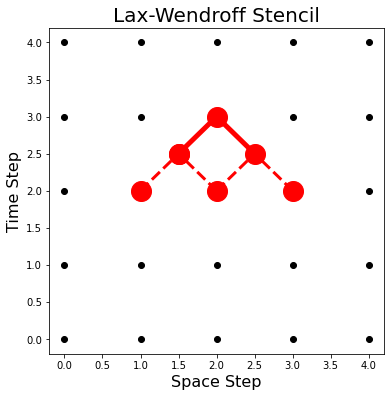

In [16]:
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

plt.figure(figsize=(6,6))
ax1.clear()

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
   
# . . Solution at point i-1
plt.plot(1,2,    'ro',ms=20)
plt.plot(1.5,2.5,'ro',ms=20)
plt.plot(2,2,    'ro',ms=20)
plt.plot([2,1.5],[3,2.5],'r-',linewidth=5)
plt.plot([2.5,2],[2.5,3],'r-',linewidth=5)

# . . Solution at point i
plt.plot(1.5,2.5,'ro',ms=20)
plt.plot(2.5,2.5,'ro',ms=20)
plt.plot(2,3,    'ro',ms=20)
plt.plot(3,2,    'ro',ms=20)
plt.plot([2,1.5],[2,2.5],'r--',linewidth=3)
plt.plot([1,1.5],[2,2.5],'r--',linewidth=3)
plt.plot([2,2.5],[2,2.5],'r--',linewidth=3)
plt.plot([3,2.5],[2,2.5],'r--',linewidth=3)

plt.ylabel('Time Step',fontsize=16)
plt.xlabel('Space Step',fontsize=16)
plt.title('Lax-Wendroff Stencil',fontsize=20)
plt.show()

**Figure 11. Illustration of the Lax-Wendroff two-step solution grid. Here, one first approximates solutions at the half step (here $n=2.5$) that are then used to calculate the solution at the full step (here $n=3$).**

For the 1D advection equation, this means solving the following two-step scheme:

$$u^{n+1/2}_{i-1/2} = \frac{1}{2} \left( u^n_i +u^n_{i-1} 
\right) -  \frac{c\Delta t}{2\Delta x} \left( u^n_i-u^n_{i-1}\right) \tag{32a}$$

$$u^{n+1/2}_{i+1/2} = \frac{1}{2} \left( u^n_{i+1} +u^n_i 
\right) -  \frac{c\Delta t}{2\Delta x} \left( u^n_{i+1}-u^n_i\right) \tag{32b}$$

$$u^{n+1}_{i} = u^n_i -  \frac{c\Delta t}{\Delta x} \left(u^{n+1/2}_{i+1/2}-u^{n+1/2}_{i-1/2}\right) \tag{32c}$$

However, by backsubstituting equations 32a and 32b into equation 32c, this scheme can be rewritten as

$$u^{n+1}_{i} = b_{-1}u^{n}_{i-1}+b_{0}u^{n}_{i}+b_{+1}u^{n}_{i+1} \tag{33a}$$

where

$$b_{-1} = \frac{C}{2}\left(C+1\right),\tag{33b}$$
$$b_{ 0} = 1-C^2,  \tag{33c}$$
$$b_{+1} = \frac{C}{2}\left(C-1\right),\tag{33d}$$

and $C=\frac{c\Delta t}{\Delta x}$ is again the **Courant number**.

In [17]:
## . . Advection equation solution
def Advection_Lax_Wendroff_Solution(U,vx,dx,dt,LB,RB):
    '''Set up Lax-Wendroff advection solution 
    usage: U = Advection_Lax_Wendroff_Solution(U,vx,dx,dt,LB,RB):
    input: 
        U : Solution at time step n (nx)
        vx: advection velocity
        dx: spatial sampling
        dt: temporal sampling
        LB: Left  boundary condition (Dirchelet)
        RB: Right boundary condition (Dirchelet)
    output:
        U: heat solution at time step n+1(nx)
    depends on:
        nothing
    
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''    
    nx = len(U)
    
    CC = vx*dt/dx

    ## . . Coefficients
    bm = CC/2*(CC+1)
    b0 = 1-CC**2
    bp = CC/2*(CC-1)
    
    ## . . Calculate soultion
    U[1:nx-1] = bm*U[0:nx-2]+b0*U[1:nx-1]+bp*U[2:nx] 
    U[0     ] = LB # . . Enforce left  boundary condition
    U[nx-1  ] = RB # . . Enforce right boundary condition
    
    return U

In [18]:
## . . Time axis parametes
nt,dt=201,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
Un = np.zeros(np.size(xx))
Up = np.zeros(np.size(xx))
Un = np.exp(-(xx-midpoint)**2/sigma**2)
Up = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
#vx= 1.0 # velocity
vx= 0.85 # velocity
#vx= 1.1 # velocity
#vx= 1.2 # velocity
LB = RB = 0 # Boundary conditions on left and right

c = np.zeros((nx,nt))
d = np.zeros((nx,nt))

for i in range(nt):
    Un = Advection_Lax_Wendroff_Solution(Un,+vx,dx,dt,LB,RB)
    c[:,i]=Un
    Up = Advection_Lax_Wendroff_Solution(Up,-vx,dx,dt,LB,RB)
    d[:,i]=Up
    
k = 0
kskip = 3

def advection_both_animate(i):
    global k
    k += 1
    ax1.clear()
    ax1.plot(xx,c[:,k],'c',xx,d[:,k],'m')
    ax1.grid(True)
    ax1.set_xlim([xmin,xmax])
    ax1.set_ylim([-1.5,1.5])
    
## . . Set up movie
fig6,ax1 = plt.subplots(1)
fig6.subplots_adjust(0.1,0.1,0.9,0.9)
fig6.set_dpi(100)

## . . Call the animator.  
anim6 = animation.FuncAnimation(fig6,advection_both_animate,frames=int((nt-kskip)/kskip),interval=50)
# anim6.save('./movies/Ex3_6.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex3_6.mp4" type="video/mp4">
</video>
""")

**Figure 12. Illustration of the Lax-Wendroff two-step solution. I have plotted both the left- (magenta) and right-going (cyan) solutions that are both stable and largely dispersion-free.**

Where we now see that we have stable and (largely) dispersion free.  In fact, one can complete a standard von Neumann stability analysis (using $\phi = k_m\Delta x$) to show that

$$g^2 = \left|1+C^2(\cos \phi)-1)+iC\sin \phi\right|^2 \le 1. \tag{34a}$$

which simplifies (thanks to Mathematica!) to

$$g^2 = C^2 \sin ^2(\phi )+\left(C^2 \cos (\phi)-C^2+1\right)^2 \le 1. \tag{34b}$$

A bit of graphical analysis can show that $g^2\le 1$ whenever $|C|\le 1$. Thus, the Lax-Wendroff approach is **conditionally stable**.

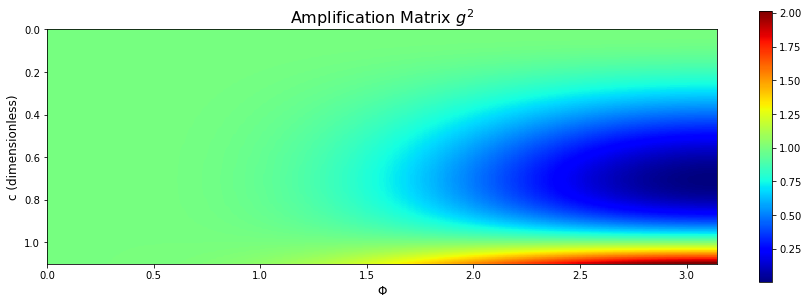

In [19]:
xmin,xmax,nx=0.,180.,91
dx= (xmax-xmin)/(nx-1)

cmin,cmax,nc=0.0,1.1,101


phi = np.linspace(xmin,xmax,nx)/180.0*np.pi
vx  = np.linspace(cmin,cmax,nc)

ggg = np.zeros((nc,nx))

for ic in range(nc):
    for ix in range(nx):
        ggg[ic,ix] = vx[ic]**2*np.sin(phi[ix])**2 + (1-vx[ic]**2+vx[ic]**2*np.cos(phi[ix]))**2

plt.figure(figsize=(15,5))
plt.xlabel('$\Phi$',fontsize=12)
plt.ylabel('c (dimensionless)',fontsize=12)
plt.title('Amplification Matrix $g^2$',fontsize=16)
plt.imshow(ggg,cmap='jet',extent=[0,np.pi,cmax,cmin],origin='upper')
plt.colorbar()
plt.show()

**Figure 13. Illustration of the zone where $g^2 \le 1$, which only occurs when $|C|\le 1$.** 

Note also that this scheme has an accuracy order of $O(\Delta x^2,\Delta ^2)$.  A further interesting observation is that this equation is equivalent to the following advection+diffusion equation:

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = D \frac{\partial^2 u}{\partial x^2}, \tag{35a}$$

where $D$ is an effective diffusion term given by:

$$D = \frac{\Delta x^2}{2\Delta t}- c^2\frac{\Delta t}{2}. \tag{35b}$$

### A Linear Algebra Framework

The shifting stencils in figure again are a **system of linear equations** that can be represented in a straightforward manner using matrix algebra in the form of ${\bf Ax}={\bf Rb}$ where ${\bf m}$ is the vector of $I$ unknown values $U^{n+1}_i$ on the left-hand side of equation 17d, ${\bf b}$ is a vector of $I$ known values on the right-hand side of equation 17d, and ${\bf A}$ and ${\bf R}$ are two matrix operators that define the mapping between ${\bf m}$ and ${\bf d}$.  Let's write this out explicitly:

$${\bf Ax} = {\bf Rb} \tag{36a}$$

which corresponds to

$$
\left[
\begin{array}{ccccccc}
1 & 0 & 0 & 0 & ... & 0& 0 &0 &0 \\
0 & 1 & 0 & 0 & ... & 0& 0 &0 &0 \\
0 & 0 & 1 & 0 & ... & 0& 0 &0 &0 \\
\vdots & \vdots & \vdots & \ddots & \vdots &\vdots &\vdots \\
0 &0&0& 0 &...& 0&1&0&0\\
0 &0&0& 0 &...& 0&0&1&0\\
0 &0&0& 0 &...& 0&0&0&1\\
\end{array}
\right]
\left[
\begin{array}{c}
U^{n+1}_0 \\
U^{n+1}_1 \\
U^{n+1}_2 \\
\vdots\\
U^{n+1}_{I-2} \\
U^{n+1}_{I-1} \\
U^{n+1}_{I} \\
\end{array}
\right]
=
\left[
\begin{array}{ccccccc}
b_0 & b_{+1} & 0 & 0&... &0& 0 &0 &0 \\
b_{-1} & b_0 & b_{+1} & 0& ... &0& 0 &0 &0 \\
0 & b_{-1} & b_0 & b_{+1} &... &0& 0 &0 &0 \\
\vdots & \vdots & \vdots & \ddots & \vdots &\vdots &\vdots \\
0 &0&0&0&...& b_{-1}&b_0&b_{+1}&0\\
0 &0&0&0&...&0 &b_{-1}&b_0&b_{+1}\\
0 &0&0&0&...&0 &0&b_{-1}&b_0\\
\end{array}
\right]
\left[
\begin{array}{c}
 U^{n}_{0} \\
 U^{n}_{1} \\
U^{n}_{2} \\
\vdots\\
U^{n}_{I-2} \\
U^{n}_{I-1} \\
 U^{n}_{I} \\
\end{array}
\right]. \tag{36b}$$

## A few thoughts on Boundary Conditions

One thing that we didn't fully cover above is the boundary condition.  Note that I have set these to be $u(0)=u(1)=0$ in the above. However, these can easily be changed. 

### Neumann Boundary Conditions

Let's say we wanted to include the following Neumann BC

$$\left.\frac{\partial u }{\partial x} = 0  \right|_{x=1} \tag{37a}$$

In this case, we can use the following approximation:

$$\frac{U^n_{nx}- U^n_{nx-1}}{\Delta x} = 0 \tag{37b}$$ 

or rearranging terms

$$ U^n_{nx}= U^n_{nx-1} \tag{37b}$$ 

which is straightforward to implement.

In [20]:
## . . Time axis parametes
nt,dt=101,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
U = np.zeros(np.size(xx))
U = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
vel= 1 # velocity
alpha = vel*dt/dx

## . . L-W coefficients (positive)
bm =   alpha/2*(alpha+1)
b0 = 1-alpha**2
bp =   alpha/2*(alpha-1)

## . . Advection equation solution
def Lax_Wendroff_Solution_Neumann(U):
    U[1:nx-1] = bm*U[0:nx-2]+b0*U[1:nx-1]+bp*U[2:nx] 
    U[0     ] = U[1  ]  # . . Enforce left  boundary condition (Neumann)
    U[nx-1  ] = U[nx-2] # . . Enforce right boundary condition (Neumann)
    return U

c = np.zeros((nx,nt))

for i in range(nt):
    U = Lax_Wendroff_Solution_Neumann(U)
    c[:,i]=U
  
k = 0
kskip = 3

## . . Set up movie
fig7,ax1 = plt.subplots(1)
fig7.subplots_adjust(0.1,0.1,0.9,0.9)
fig7.set_dpi(100)

## . . Call the animator.  
anim7 = animation.FuncAnimation(fig7,advection_animate,frames=int((nt-kskip)/kskip),interval=100)
anim7.save('./movies/Ex3_7.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex3_7.mp4" type="video/mp4">
</video>
""")

**Figure 3-14. Illustration of the Lax-Wendroff two-step solution grid using Neumann boundary conditions.**

### Circular (Periodic) Boundary Conditions

Another boundary condition that is sometimes used is the **circular** or **periodic** boundary condition.  This is where you want to have a problem that is disappearing from one side of the grid appearing on the other. In this case, one can enforce the following:

$$u^{n}_{0} = u^{n}_{nx-2} \tag{38a}$$

and

$$u^{n}_{nx-1} = u^{n}_{1}. \tag{38b}$$

The effect of setting these boundary conditions is illustrated in the figure below.

In [21]:
## . . Time axis parametes
nt,dt=101,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
U = np.zeros(np.size(xx))
U = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
vel= 1 # velocity
alpha = vel*dt/dx

## . . L-W coefficients (positive)
bm = alpha/2*(alpha+1)
b0 = 1-alpha**2
bp = alpha/2*(alpha-1)

## . . Advection equation solution
def Lax_Wendroff_Solution_Circular(U):
    U[1:nx-1] = bm*U[0:nx-2]+b0*U[1:nx-1]+bp*U[2:nx] 
    U[0     ] = U[nx-2]  # . . Enforce left  boundary condition
    U[nx-1  ] = U[1] # . . Enforce right boundary condition
    return U

c = np.zeros((nx,nt))

for i in range(nt):
    U = Lax_Wendroff_Solution_Circular(U)
    c[:,i]=U
  
k = 0
kskip=3

## . . Set up movie
fig8,ax1 = plt.subplots(1)
fig8.subplots_adjust(0.1,0.1,0.9,0.9)
fig8.set_dpi(100)

## . . Call the animator.  
anim8 = animation.FuncAnimation(fig8,advection_animate,frames=int((nt-kskip)/kskip),interval=100)
anim8.save('./movies/Ex3_8.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex3_8.mp4" type="video/mp4">
</video>
""")

**Figure 15. Illustration of the Lax-Wendroff two-step solution grid using circular (periodic) boundary conditions.**